In [3]:
# Imports for the notebook
import sys
import numpy as np
import control as c
from control.matlab import *
import matplotlib.pyplot as plt
from IPython.display import Latex

In [6]:
from wand.image import Image as WImage
# Insert figures: 
#img1 = WImage(filename='./figures_ch8/pid_complex_poles.pdf')
#img2 = WImage(filename='./figures_ch8/pid_damping_ratio.pdf')

# Part 3: PID Control Design
## Chapter 8: Design Strategies for Second-order Systems

### Lecture Notes

This notebook covers the material in Chapter 8 of the text in brief form, allowing you to make changes and manipulate the examples.  The goal is for this resource to help you bridge the gap between theory and the practical. 

## Section A: First Order Response

Consider a first order system given by
$$Y(s) = \frac{p}{s+p} U(s),$$
where $p>0$.  The pole location of the first order system is at $-p$.  

If $U(s)=\frac{A}{s}$ is a step of magnitude $A$, then 
$$Y(s) = \frac{Ap}{s(s+p)}.$$

The inverse Laplace transform is given by
\begin{equation}\label{eq:PID_first_order_response}
y(t) = \begin{cases} A(1-e^{-pt}), & t\geq 0 \\ 0, & \text{otherwise} \end{cases}.
\end{equation}

### Step Size Impacts
The response is shown in the figure below, which shows the response to steps of size $A=1$, $A=2$, and $A=3$, respectively.

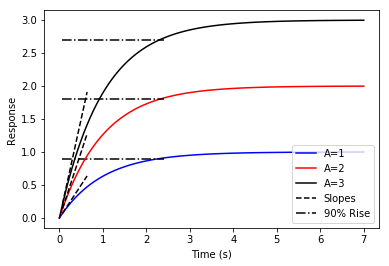

In [52]:
# Plot our basic TF with different magnitudes of A
p = 1
A = [1,2,3]

num = A*p
den = [1.,p]

H0 = c.tf(num[0],den)
H1 = c.tf(num[1],den)
H2 = c.tf(num[2],den)

# Step responses
y0, t = step(H0)
y1, t1 = step(H1,t)
y2, t2 = step(H2,t)

# Initial slopes:
ts = t[1:10]
s0 = (A[0]/p)*ts 
s1 = (A[1]/p)*ts
s2 = (A[2]/p)*ts

# 90% rise times
t9 = t[1:35]
r0 = 0.9*A[0]*np.ones(t9.size)
r1 = 0.9*A[1]*np.ones(t9.size)
r2 = 0.9*A[2]*np.ones(t9.size)

fig, ax = plt.subplots()
ax.plot(t,y0,'b',label='A=1')
ax.plot(ts,s0,'k--')
ax.plot(t9,r0,'k-.')
ax.plot(t1,y1,'r',label='A=2')
ax.plot(ts,s1,'k--')
ax.plot(t9,r1,'k-.')
ax.plot(t2,y2,'k',label='A=3')
ax.plot(ts,s2,'k--',label='Slopes')
ax.plot(t9,r2,'k-.',label='90% Rise')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()

If we define the rise time $t_r$ of the system to be the **time after the step when the response reaches 90\%** of its final value, then note from the figure above that the *rise time is independent of the step size $A$.*  

By differentiating the time response equation above,at time $t=0$, it is straightforward to show that the slope of the response at $t=0$ is equal to $Ap$.  This is also shown graphically in the figure above.

### Pole Location Impacts
Next we discuss how changes in the pole location $p$ adjust the performance of the system.  As we vary p, see what takes place: 

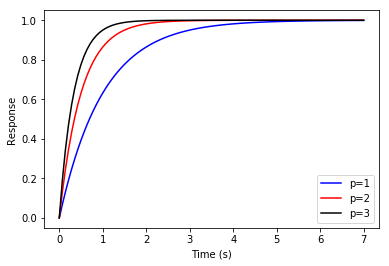

In [66]:
p2 = [1,2,3]
A2 = 1

num = p2*A2
den0 = [1.,p2[0]]
den1 = [1.,p2[1]]
den2 = [1.,p2[2]]

H0 = c.tf(num[0],den0)
H1 = c.tf(num[1],den1)
H2 = c.tf(num[2],den2)

# Step responses
y0, t = step(H0)
y1, t1 = step(H1,t)
y2, t2 = step(H2,t)

fig, ax = plt.subplots()
ax.plot(t,y0,'b',label='p=1')
ax.plot(t1,y1,'r',label='p=2')
ax.plot(t2,y2,'k',label='p=3')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()  

Note that as the pole location moves further into the left half of the complex plane, the rise time decreases.

### DC Gain
An important concept for the steady state response of a system is the **DC-gain**, which is defined as follows.
{\bf Definition}:
The DC-gain of a transfer function $H(s)$ is
$$\left. H(s)\right|_{\text{DC-gain}} = \lim_{s\to 0} H(s).$$

An important fact is that if the poles of $H(s)$ are in the open left half plane, then the response of $H(s)$ to a step of size $A$ approaches $A \left.H(s)\right|_{\text{DC-gain}}$ as $t\to\infty$.  This is true for first order systems, as well general $H(s)$. 

The DC gain, for our first example above, is then 
$$\left. H(s)\right|_{\text{DC-gain}} = \lim_{s\to 0}  \frac{p}{s+p} =  1.$$

## Section B: Second Order Systems
Suppose that the closed-loop system has a second order transfer function with two real poles and no zeros:
$$Y(s) = \frac{K}{(s+p_1)(s+p_2)}Y_r(s).$$

To find the output of the system when the input is a step of magnitude $A$, we find the inverse Laplace transform of
$$Y(s) = \frac{K}{(s+p_1)(s+p_2)}\frac{A}{s}.$$ (See text for more steps)

Taking the inverse Laplace transform gives
$$y(t) = \begin{cases}
		\frac{KA}{p_1p_2} + \frac{KA}{(-p_1)(p_2-p_1)}e^{-p_1t} + \frac{KA}{(-p_2)(p_1-p_2)} e^{-p_2t}, & t\geq 0 \\
		0, & \text{otherwise}
		\end{cases}.$$
Note that as $t\to\infty$ that $y(t)\to \frac{KA}{p_1p_2}$ which is equal to the step size $A$ times the DC-gain of the system.  
### Generic Second Order System
Now suppose that the closed loop system has two complex poles and no zeros.  We will write a generic second order system with poles in the left half plane using the notation
$$H(s) = \frac{K\omega_n^2}{s^2 + 2\zeta\omega_n s + \omega_n^2},$$
were $K$ is the DC-gain of the system (typically $K=1$), $\omega_n>0$ is called the **natural frequency**, and $\zeta>0$ is called the **damping ratio**. 

The poles are given by the roots of the characteristic polynomial
$$\Delta(s) = s^2 + 2\zeta\omega_n s + \omega_n^2,$$
in other words, the poles are
\begin{align*}
p_{1,2} &= -\zeta\omega_n \pm \sqrt{(\zeta\omega_n)^2-\omega_n^2} \\
  &= -\zeta\omega_n \pm \omega_n\sqrt{\zeta^2-1}.
\end{align*}

If $0<\zeta<1$, then the roots are complex and given by
\begin{equation}\label{eq:complex_poles}
p_{1,2} = -\zeta\omega_n \pm j\omega_n\sqrt{1-\zeta^2}.
\end{equation}

In [64]:
# Show how the step repsonse of the system changes with w_n and zeta
zeta = 0.707
fig, ax
for wn = [.5, 1, 2, 5]
    G = tf(wn^2,[1,2*zeta*wn,wn^2])
    g,t = step(G)
    ax.plot(t,g,)

#figure(2), clf
wn = 1;
for zeta=[.2, .4, .707, 1, 2],
    G = tf(wn^2,[1,2*zeta*wn,wn^2]);
    #step(G)
    #hold on

SyntaxError: invalid syntax (<ipython-input-64-61c7087e1f9b>, line 4)

Note from the figures above that as the natural frequency increases, the rise time decreases. We should note that a similar phenomena to the first order response also occurs, where the rise time is independent of the size of the step.  

Note from the above figures that the damping ratio effects the amount of ringing in the system.  For a small damping ratio, e.g., $\zeta=0.2$ there is a large overshoot and significant ringing in the system.  At the other extreme, when $\zeta$ is larger than one, the poles are real and the response is highly damped.  The sweet spot is when $\zeta=0.707$ where the rise time is small, but the overshoot is minimal. 

### Complex Plane
In the complex plane, the pole locations are shown in the next figure, where $\omega_n$ is the distance from origin to the poles.  When $\zeta=\frac{1}{\sqrt{2}}$ the angle $\theta$ equals $45$ degrees.  

In [ ]:
#img1

In rectangular coordinates, the poles are given by
\begin{equation}\label{eq:complex_rectangular}
p_{1,2} = -\sigma \pm j\omega_d,
\end{equation}
as shown above. 

We also have
\begin{align*}
\sigma &= \zeta \omega_n \\
\omega_d &= \omega_n\sqrt{1-\zeta^2}.
\end{align*}

From the above figure, it is also clear that
$$\sin\theta = \frac{\sigma}{\omega_n} = \zeta.$$
Therefore
$$\theta = \sin^{-1} \zeta.$$

### System Damping
Since the pole locations are at $-\zeta \omega_n \pm \omega_n \sqrt{\zeta^2-1}$ there are three possible configurations:
* The poles are both real if $\zeta> 1$. The system is referred to as **over damped**. 
* When $\zeta=1$ the poles are real and both located at $-\omega_n$.  The system is referred to as **critically damped** 
* When $0<\zeta<1$ the are imaginary and occur in complex conjugate pairs.  The system is referred to as **under damped**   

This concept is demonstrated visually in the figure below. 

In [ ]:
#img2

### Rise Time for Second Order Systems

The rise time is defined to be time that it takes the output to transition from 10\% to 90\% of its final value $A$. A suitable approximation is that the rise time is one half of the peak time, which is the time when $y(t)$ reaches its first peak.  

To find the peak time $t_p$, differentiate $y(t)$ and then solve for the first instant of time when the derivative is zero.  The result is
$$
t_p = \frac{\pi}{\omega_d} = \frac{\pi}{\omega_n\sqrt{1-\zeta^2}}.
$$
Therefore, the rise time is approximately
$$
t_r \approx \frac{1}{2}t_p = \frac{1}{2}\frac{\pi}{\omega_n\sqrt{1-\zeta^2}}.
$$
When $\zeta=0.707$ we get
\begin{equation}\label{eq:rise_time}
t_r \approx \frac{2.2}{\omega_n}.
\end{equation}

Specifications for second order systems are usually given either in terms of the rise time $t_r$ and the damping ratio $\zeta$, or in terms of the natural frequency $\omega_n$ and the damping ratio $\zeta$.

## Section C: Impact of Zero on Step Response

Review the deriation of the effects of a zero on a notional second order system in the text.  Here we demonstrate an interactive plot for placing the zero. 

In [ ]:
# Select the zero location and observe the impact on the overall system performance
z = 0; # Want z to be in the left-half plane (so negative)

# Compute the effect and plot
A = 6; 
den = [1 5 6]
num = A
if(z == 0)
    numz = [A,0]
else
    numz = A/z*[1 -z]
    
H0 = c.tf(num,den)
Hz = c.tf(numz,den)




# Example: Design Study A: Single-link Robot Arm

In [2]:
# TODO: Place these in the appropriate example folder below
# Design Problem A : Arm
sys.path.append('./arm/')
sys.path.append('./arm/hw8/')  # add homework directory
import armParam as P
from armDynamics import armDynamics
from armController import armController
from signalGenerator import signalGenerator
from armAnimation import armAnimation
from plotData import plotData

kp:  0.18
kd:  0.095
